# Project: Transfer Learning in PyTorch 
## Part 2. Training the classifier of a pretrained model

In this notebook, PyTorch pretrained model with a custom a classifier will be trained to identify 102 different flowers. 

### Dataset: Flower 102

The dataset is the [Oxford 102 collection](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) of flowers

In [1]:
from torchvision import transforms, models, datasets
from torch import optim, cuda
import torch
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import numpy as np
import pandas as pd
import os, glob, math, random
from PIL import Image
from torchsummary import summary
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 14
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'


### Parameters

One of the benefits of using PyTorch is that it's easy to move the model or data to CPU, GPU or to multiple GPUs. 

In [2]:
datadir = './flower_data/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'valid/'

saved_model = 'model_trained.pth'
batch_size = 256
train_on_gpu = cuda.is_available()
print(train_on_gpu)

True


# Image Preprocessing

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image `transforms`, which prepare our data for a neural network.

### Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch `Tensor`s before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet. 

In [3]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch). 

In [4]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

## The shape of a batch is 
(batch_size, color_channels, height, width). 

In [5]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

In [6]:
n_classes = len(data['train'].classes)
print('There are {} different classes.'.format(n_classes))

There are 102 different classes.


We can iterate through the `DataLoaders` when doing training, validation, and testing. This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the `Random` transformations will be different so the network will essentially see multiple versions of each training image. 

# Pre-Trained Models for Image Classification

PyTorch has many pretrained models. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories.

## Approach

The approach for using a pre-trained image recognition model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
    * Layers to freeze can be adjusted depending on similarity of task to large training dataset
3. Replace the classifier (fully connected) part of the network with a custom classifier
    * Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
    * Optimizer model classifier for smaller dataset


### Function to Load in Pretrained Model

In [7]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
                         nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

if train_on_gpu:
    model = model.to('cuda')
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [256, 64, 112, 112]           9,408
       BatchNorm2d-2        [256, 64, 112, 112]             128
              ReLU-3        [256, 64, 112, 112]               0
         MaxPool2d-4          [256, 64, 56, 56]               0
            Conv2d-5          [256, 64, 56, 56]           4,096
       BatchNorm2d-6          [256, 64, 56, 56]             128
              ReLU-7          [256, 64, 56, 56]               0
            Conv2d-8          [256, 64, 56, 56]          36,864
       BatchNorm2d-9          [256, 64, 56, 56]             128
             ReLU-10          [256, 64, 56, 56]               0
           Conv2d-11         [256, 256, 56, 56]          16,384
      BatchNorm2d-12         [256, 256, 56, 56]             512
           Conv2d-13         [256, 256, 56, 56]          16,384
      BatchNorm2d-14         [256, 256,

In [8]:
print("Layer to train", model.fc)

Layer to train Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=102, bias=True)
  (4): LogSoftmax()
)


## Mapping of Classes to Indexes

To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [18]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(list(cat_to_name.items())[:6])

class_to_idx = data['train'].class_to_idx
idx_to_name = {idx: cat_to_name[category] for category, 
               idx in data['train'].class_to_idx.items()}
print(list(idx_to_name.items())[:6])

model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {idx: cat_to_name[category] for category, 
               idx in data['train'].class_to_idx.items()}
print(list(model.idx_to_class.items())[:10])

[('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster'), ('27', 'prince of wales feathers')]
[(0, 'pink primrose'), (1, 'globe thistle'), (2, 'blanket flower'), (3, 'trumpet creeper'), (4, 'blackberry lily'), (5, 'snapdragon')]
[(0, 'pink primrose'), (1, 'globe thistle'), (2, 'blanket flower'), (3, 'trumpet creeper'), (4, 'blackberry lily'), (5, 'snapdragon'), (6, "colt's foot"), (7, 'king protea'), (8, 'spear thistle'), (9, 'yellow iris')]


# Training Loss and Optimizer

The loss is the negative log likelihood and the optimizer is the Adam optimizer. The negative log likelihood in PyTorch expects log probabilities so we need to pass it the raw output from the log softmax in our model's final layer. The optimizer is told to optimizer the model parameters (only a few of which require a gradient). 

* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients 

In [10]:
criterion = nn.NLLLoss()
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

Below we can look at the parameters (weights) that will be updated by the optimizer during training.

In [11]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([102, 256])
torch.Size([102])


# Training

For training, we iterate through the train `DataLoader`, each time passing one batch through the model. One complete pass through the training data is known as an `epoch`, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with `criterion(output, targets)`) and then calculate the gradients of the loss with respect to the model parameters with `loss.backward()`. This uses autodifferentiation and backpropagation to calculate the gradients. 

After calculating the gradients, we call `optimizer.step()` to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). For each batch, we also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping.


## Early Stopping

Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.

Early stopping is implemented by iterating through the validation data at the end of each training epoch and calculating the loss. We use the complete validation data every time and record whether or not the loss has decreased. If it has not for a number of epochs, we stop training, retrieve the best weights, and return them. When in the validation loop, we make sure not to update the model parameters. 

### Training Function

The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set. There are a number of parameters that I've tried to explain in the doc string. Hopefully, the comments and background make things somewhat understandable! 

In [12]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    
    """Train a PyTorch Model
    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    save_file_name = "./epochs/epoch"
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []
    
    try:
        print("Model has been trained for: {} epochs.",format(model.epochs))
    except:
        model.epochs = 0
        print("Starting Training from epoch 0")

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()
                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()
                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f}\tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    save_state = save_file_name+"_{:03d}.pt".format(epoch)
                    # Save model
                    torch.save(model.state_dict(), save_state)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop and valid_acc < train_acc :
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_state))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=['train_loss','valid_loss','train_acc','valid_acc'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [13]:
model, history = train( model, criterion, optimizer, dataloaders['train'], dataloaders['val'], n_epochs=30)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 66.96 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.2808	Validation Loss: 1.6427
		Training Accuracy: 52.78%	 Validation Accuracy: 66.63%
Epoch: 3	100.00% complete. 66.99 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.9813	Validation Loss: 0.7779
		Training Accuracy: 77.24%	 Validation Accuracy: 84.84%
Epoch: 5	100.00% complete. 66.97 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6172	Validation Loss: 0.5447
		Training Accuracy: 85.30%	 Validation Accuracy: 88.14%
Epoch: 7	100.00% complete. 66.89 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.4865	Validation Loss: 0.4561
		Training Accuracy: 87.88%	 Validation Accuracy: 89.49%
Epoch: 9	100.00% complete. 66.86 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.3917	Validation Loss: 0.3918
		Training Accuracy: 90.22%	 Validation Accuracy: 91.81%
Epoch: 11	100.00% complete. 66.76 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.3340	Validation Los

# Training Results

We can inspect the training progress by looking at the `history`. 

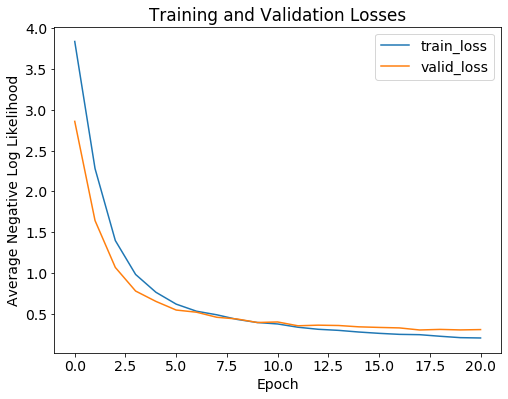

In [14]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses');

As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss stops decreasing. There is not a massive amount of overfitting, likely because we were using Dropout. With the divergence in losses, there is likely not much more to gain from further training.

Text(0.5, 1.0, 'Training and Validation Accuracy')

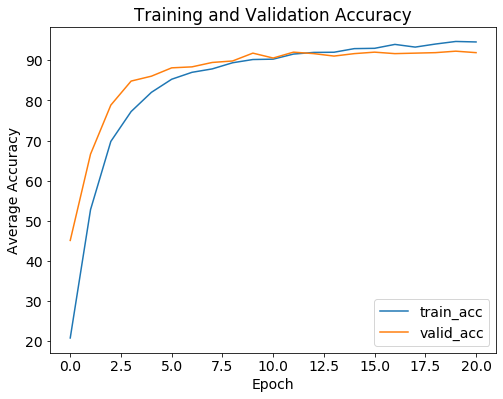

In [15]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

As with the losses, the training accuracy increases (nearly to perfect) while the validation accuracy plateaus. The model is able to achieve above 90% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

## Saving complete model

The `train` function saves the best model `state_dict()` which are the weights of the model. To save more information about the model, we use the below function. 

In [27]:
def save_complete_model(model, path):

    checkpoint = {'class_to_idx': model.class_to_idx,
                  'idx_to_class': model.idx_to_class,
                        'epochs': model.epochs }

    # final classifier and the state dictionary
    checkpoint['fc'] = model.fc
    checkpoint['state_dict'] = model.state_dict()

    # optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    torch.save(checkpoint, path)
    print("saving {} to ()".format(model, path))

In [28]:
save_complete_model(model, saved_model)

saving ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

## Loading in a complete model

In [29]:
def load_complete_model(path):
    checkpoint = torch.load(path)

    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = checkpoint['fc']
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
   
    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

### Verify that the saved model can be loaded back

In [30]:
loaded_model, loaded_optimizer = load_complete_model(saved_model)
#summary(loaded_model, input_size=(3, 224, 224), batch_size=batch_size)

### Continue training (might not work)

Sometimes PyTorch doesn't release VRAM, so attempting to continue training will trigger `cuda out off memory` error. In this case, restart kernel, reload the model and continue the training.  

In [ ]:
model, history = train( loaded_model, criterion, loaded_optimizer, dataloaders['train'],
                         dataloaders['val'], max_epochs_stop=10, n_epochs=40)
save_complete_model(model, "continued_train.pth")

Model has been trained for: 57 epochs.

